In [1]:
import sys
import torch.nn as nn
import torch
import warnings
import re
import numpy as np
import collections
import matplotlib.pyplot as plt
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")


class TimeMachine(d2l.DataModule): #@save
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+', ' ', text).lower()

    def _tokenize(self, text):
        return list(text)
    
    def build(self, raw_text, vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None: vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab
    
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

# 1. In the experiment of this section, tokenize text into words and vary the min_freq argument value of the Vocab instance. Qualitatively characterize how changes in min_freq impact the size of the resulting vocabulary.

In [2]:
data = TimeMachine()
raw_text = data._download()
text = data._preprocess(raw_text)
words = text.split()

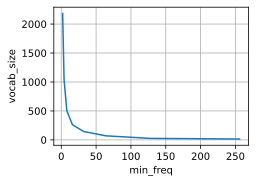

In [3]:
min_freqs = d2l.gen_logrithm_nums(initial_value = 2,num_elements=8)
vocab_size = []
for min_freq in min_freqs:
    vocab = Vocab(words, min_freq=min_freq)
    vocab_size.append(vocab.__len__())
d2l.plot(min_freqs, vocab_size, 'min_freq', 'vocab_size')

# 2. Estimate the exponent of Zipfian distribution for unigrams, bigrams, and trigrams in this corpus.

In [4]:
class FreqData(d2l.SyntheticRegressionData):
    def __init__(self, X, y, num_train=1000, batch_size=32):
        self.save_hyperparameters()
        
def estimate_exp(words):
    vocab = Vocab(words)
    freqs = torch.log(torch.tensor([freq for w, freq in vocab.token_freqs])).reshape(-1,1)
    rank = torch.log(torch.range(1, len(freqs))).reshape(-1,1)
    data = FreqData(X=rank, y=freqs)
    model = d2l.LinearRegression(1)
    trainer = d2l.Trainer(max_epochs=5)
    trainer.fit(model, data)
    w = model.net.weight.item()
    plt.figure(figsize=(5, 3))
    plt.scatter(rank.detach().numpy(), freqs.detach().numpy(), label="Data")
    plt.plot(rank.detach().numpy(), model(rank).detach().numpy(), 'r-', label="Fitted Power Law")
    plt.xlabel("Rank")
    plt.ylabel("Frequency")
    plt.title(f"Estimated Exponent (s): {w:.2f}")
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"Estimated Exponent (s): {w:.2f}")

In [5]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
trigram_tokens = ['--'.join(pair) for pair in zip(words[:-2], words[1:], words[2:])]

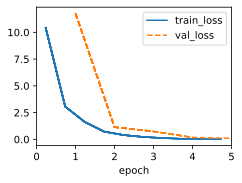

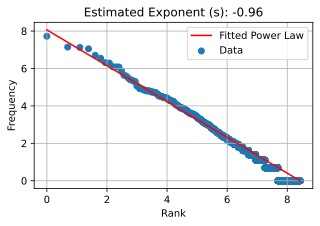

Estimated Exponent (s): -0.96


In [6]:
estimate_exp(words)

# 3. Find some other sources of data (download a standard machine learning dataset, pick another public domain book, scrape a website, etc). For each, tokenize the data at both the word and character levels. How do the vocabulary sizes compare with The Time Machine corpus at equivalent values of min_freq. Estimate the exponent of the Zipfian distribution corresponding to the unigram and bigram distributions for these corpora. How do they compare with the values that you observed for The Time Machine corpus?¶